In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
plt.rc('font',family = 'SimHei',size = 13)
import datetime

In [2]:
path = "Data_L1.csv"
data = pd.read_csv(path)

data.Date = pd.to_datetime(data.Date,format = '%d/%m/%Y')
data = data[(data['Date']<'2011-12-01')]
data['Cancel_Invoice'] = data.Invoice.str.startswith('C')

data['GMV'] = data['Quantity'] * data['Price'] 

data['First_Purchase'] = data.groupby('Customer ID')['Date'].transform('min')

data['Cohort_Index'] = (data.Date.dt.year - data.First_Purchase.dt.year) * 12 + (data.Date.dt.month - data.First_Purchase.dt.month)

data['Country_Cust'] = data.sort_values(['Customer ID','Date','Invoice']).groupby(['Customer ID'])['Country'].transform('first')

data['Country_Group'] = data.Country_Cust.apply(lambda x:'UK' if x =='United Kingdom' else 'Others')

data['Cohort_Month'] = data.First_Purchase.dt.year * 100 + data.First_Purchase.dt.month

data['Invoice_Year'] = data.Date.dt.year

data['Invoice_Month'] = data.Date.dt.month

data['Inv_YM'] = data['Invoice_Year'] * 100 + data['Invoice_Month']
print('Min:{};Max:{}'.format(min(data.Date),max(data.Date)))

Min:2009-12-01 00:00:00;Max:2011-11-30 00:00:00


In [3]:
churn_feature_list = pd.read_csv('Feature_list0.csv')
churn_feature_list  = churn_feature_list.drop('Unnamed: 0',axis=1)
churn_feature_list = churn_feature_list.set_index('Customer ID')

In [4]:
churn_feature_list

,1st_GMV,GMV,1st_Product_Wide,Product_Wide,Nos_of_purchase,1st_Month_Frequency,Price_Mean,Churn,Type,Tag_Price,Tag_GMV,Tag_PW
Customer ID,,,,,,,,,,,,
12346,45.00,77556.46,1,27,11,5,6.100000,1,Old Customer,[5-11),<50,1
12347,611.53,5408.50,40,123,7,1,2.605868,0,Old Customer,[2-3),600-650,40-44
12348,222.16,2019.40,20,25,5,1,3.786275,0,Old Customer,[3-4),200-250,20-24
12349,1068.52,4428.69,46,138,4,1,8.459657,0,Old Customer,[5-11),>=1000,>=45
12350,334.40,334.40,17,17,1,1,3.841176,1,Old Customer,[3-4),300-350,15-19
...,...,...,...,...,...,...,...,...,...,...,...,...
18283,101.35,2528.65,40,348,11,1,1.767489,0,Old Customer,[1-2),100-150,40-44
18284,461.68,461.68,28,28,1,1,3.253214,1,Old Customer,[3-4),450-500,25-29
18285,427.00,427.00,12,12,1,1,8.350000,1,Old Customer,[5-11),400-450,10-14


In [5]:
churn_feature_list['Churn'].value_counts()/churn_feature_list['Churn'].count()

0    0.560567
1    0.439433
Name: Churn, dtype: float64

In [6]:
Features = churn_feature_list.iloc[:,:len(churn_feature_list.columns)-5].columns
Features

Index(['1st_GMV', 'GMV', '1st_Product_Wide', 'Product_Wide', 'Nos_of_purchase',
       '1st_Month_Frequency', 'Price_Mean'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(churn_feature_list[Features], churn_feature_list['Churn'],test_size = 0.3, random_state = 7)

In [8]:
train_x.shape

(4097, 7)

In [9]:
train_y.shape

(4097,)

In [10]:
test_x.shape

(1756, 7)

In [11]:
test_y.shape

(1756,)

In [12]:
from sklearn.tree import DecisionTreeClassifier

mytree = DecisionTreeClassifier(max_depth=2,random_state=0)
mytree.fit(train_x,train_y)

from sklearn.metrics import accuracy_score, precision_score, recall_score

pred_train_y = mytree.predict(train_x)

train_accuracy = accuracy_score(train_y,pred_train_y)
print('Train accuracy:',round(train_accuracy,4))

pred_test_y = mytree.predict(test_x)
test_accuracy = accuracy_score(test_y,pred_test_y)

print('Test accuracy:',round(test_accuracy,4))

Train accuracy: 0.6986
Test accuracy: 0.6896


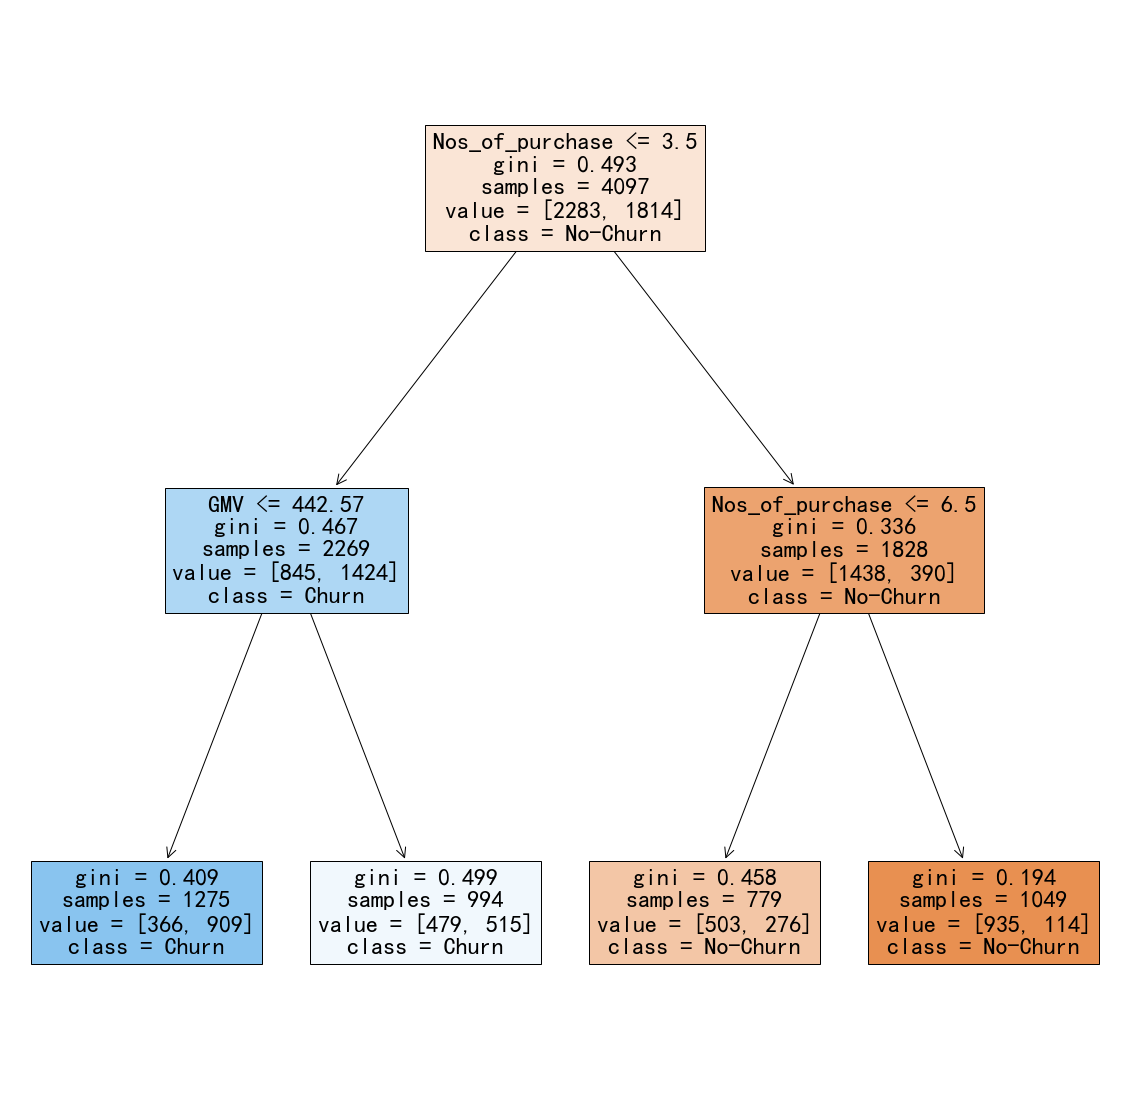

In [13]:
from sklearn import tree

fig = plt.figure(figsize = (20,20))
tree.plot_tree(mytree,feature_names = Features,class_names =['No-Churn','Churn'],filled = True)

plt.show()

In [14]:
importances = mytree.feature_importances_

sorted_index = np.argsort(importances)

feature_imp = pd.DataFrame({'Features':Features,'importance':importances}).sort_values('importance',ascending = False)

feature_imp[feature_imp.importance>0]

,Features,importance
4,Nos_of_purchase,0.904448
1,GMV,0.095552


In [15]:
pred_dataset=churn_feature_list
pred_dataset.head()

,1st_GMV,GMV,1st_Product_Wide,Product_Wide,Nos_of_purchase,1st_Month_Frequency,Price_Mean,Churn,Type,Tag_Price,Tag_GMV,Tag_PW
Customer ID,,,,,,,,,,,,
12346,45.00,77556.46,1,27,11,5,6.100000,1,Old Customer,[5-11),<50,1
12347,611.53,5408.50,40,123,7,1,2.605868,0,Old Customer,[2-3),600-650,40-44
12348,222.16,2019.40,20,25,5,1,3.786275,0,Old Customer,[3-4),200-250,20-24
12349,1068.52,4428.69,46,138,4,1,8.459657,0,Old Customer,[5-11),>=1000,>=45
12350,334.40,334.40,17,17,1,1,3.841176,1,Old Customer,[3-4),300-350,15-19


In [16]:
Features_F = pred_dataset.iloc[:,:len(pred_dataset.columns)-5].columns
Features_F

Index(['1st_GMV', 'GMV', '1st_Product_Wide', 'Product_Wide', 'Nos_of_purchase',
       '1st_Month_Frequency', 'Price_Mean'],
      dtype='object')

In [17]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(churn_feature_list[Features_F], churn_feature_list['Churn'],test_size = 0.3, random_state = 7)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score

# Inistantiate the classifier
clf = RandomForestClassifier(random_state = 1)

# Fit to the data
clf.fit(train_x,train_y)

pred_train_y = clf.predict(train_x)
train_accuracy = accuracy_score(train_y,pred_train_y)
print('Train_accuracy:',round(train_accuracy,4))

pred_test_y = clf.predict(test_x)
test_accuracy = accuracy_score(test_y, pred_test_y)
print('Test accuracy:',round(test_accuracy,4))

Train_accuracy: 0.9995
Test accuracy: 0.6822


In [19]:
importances = clf.feature_importances_

Feature_imp = pd.DataFrame({'Feature':Features_F,'importance':importances}).sort_values('importance',ascending = False)

Feature_imp

,Feature,importance
1,GMV,0.223784
6,Price_Mean,0.172712
3,Product_Wide,0.168137
0,1st_GMV,0.159162
4,Nos_of_purchase,0.143767
2,1st_Product_Wide,0.114324
5,1st_Month_Frequency,0.018114


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
pred_train_y = clf.predict(train_x)
pred_test_y = clf.predict(test_x)

train_accuracy = accuracy_score(train_y, pred_train_y)
test_accuracy = accuracy_score(test_y,pred_test_y)
print('Train_accuracy:',round(train_accuracy,4))
print('Test accuracy:',round(test_accuracy,4))

train_precision = round(precision_score(train_y,pred_train_y),4)
test_precision = round(precision_score(test_y,pred_test_y),4)
train_recall = round(recall_score(train_y,pred_train_y),4)
test_recall = round(recall_score(test_y,pred_test_y),4)
print('Training precision:{}, Training recall:{}'.format(train_precision, train_recall))
print('Test precision:{}, Test recall:{}'.format(train_recall, test_recall))

Train_accuracy: 0.9995
Test accuracy: 0.6822
Training precision:0.9989, Training recall:1.0
Test precision:1.0, Test recall:0.6346


In [21]:
clf.get_params(deep = True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [22]:
from sklearn.model_selection import GridSearchCV

# create the hyperparameter grid
param_grid = {"min_samples_leaf":[0.001,0.003,0.005],
              'max_features':range(4,7),
              'criterion':["gini","entropy"]
             }

# call gridSearchCV
grid_search = GridSearchCV(clf,param_grid,scoring ='accuracy')

grid_search.fit(train_x,train_y)
grid_search.best_params_

grid_search.best_score_

grid_search.best_estimator_

best_model = grid_search.best_estimator_

pred_train_y = best_model.predict(train_x)
pred_test_y = best_model.predict(test_x)

train_precision = round(precision_score(train_y,pred_train_y),4)
test_precision = round(precision_score(test_y,pred_test_y),4)
train_recall = round(recall_score(train_y,pred_train_y),4)
test_recall = round(recall_score(test_y,pred_test_y),4)
train_accuracy = accuracy_score(train_y, pred_train_y)
test_accuracy = accuracy_score(test_y,pred_test_y)
print('Train_accuracy:',round(train_accuracy,4))
print('Test accuracy:',round(test_accuracy,4))
print('Training precision:{}, Training recall:{}'.format(train_precision, train_recall))
print('Test precision:{}, Test recall:{}'.format(train_recall, test_recall))

In [23]:
clf3 = RandomForestClassifier(criterion = 'gini',max_features=5, min_samples_leaf=0.005, random_state=1)
clf3.fit(train_x,train_y)

pred_train_y = clf3.predict(train_x)
train_accuracy = accuracy_score(train_y, pred_train_y)
print('Train_accuracy:',round(train_accuracy,4))

pred_test_y = clf3.predict(test_x)
test_accuracy = accuracy_score(test_y,pred_test_y)
print('Test accuracy:',round(test_accuracy,4))

train_precision = round(precision_score(train_y,pred_train_y),4)
test_precision = round(precision_score(test_y,pred_test_y),4)
train_recall = round(recall_score(train_y,pred_train_y),4)
test_recall = round(recall_score(test_y,pred_test_y),4)
print('Training precision:{}, Training recall:{}'.format(train_precision, train_recall))
print('Test precision:{}, Test recall:{}'.format(train_recall, test_recall))

Train_accuracy: 0.7667
Test accuracy: 0.7141
Training precision:0.7284, Training recall:0.7541
Test precision:0.7541, Test recall:0.7124


In [24]:
result = churn_feature_list

result['pred'] = clf3.predict(churn_feature_list[Features])

In [25]:
result.describe()

,1st_GMV,GMV,1st_Product_Wide,Product_Wide,Nos_of_purchase,1st_Month_Frequency,Price_Mean,Churn,pred
count,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000,5853.000000
mean,414.892019,2942.972559,24.056040,81.012301,4.350589,1.218862,8.606924,0.439433,0.461644
std,731.611706,14338.715259,22.892463,115.114052,3.550644,0.598277,176.692016,0.496360,0.498569
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,168.550000,343.450000,9.000000,19.000000,1.000000,1.000000,2.294643,0.000000,0.000000
50%,298.100000,875.970000,18.000000,44.000000,3.000000,1.000000,2.971423,0.000000,0.000000
75%,454.360000,2263.300000,31.000000,101.000000,7.000000,1.000000,3.861033,1.000000,1.000000
max,33167.800000,597336.110000,259.000000,2515.000000,11.000000,5.000000,10953.500000,1.000000,1.000000


In [26]:
result.head()

,1st_GMV,GMV,1st_Product_Wide,Product_Wide,Nos_of_purchase,1st_Month_Frequency,Price_Mean,Churn,Type,Tag_Price,Tag_GMV,Tag_PW,pred
Customer ID,,,,,,,,,,,,,
12346,45.00,77556.46,1,27,11,5,6.100000,1,Old Customer,[5-11),<50,1,0
12347,611.53,5408.50,40,123,7,1,2.605868,0,Old Customer,[2-3),600-650,40-44,0
12348,222.16,2019.40,20,25,5,1,3.786275,0,Old Customer,[3-4),200-250,20-24,0
12349,1068.52,4428.69,46,138,4,1,8.459657,0,Old Customer,[5-11),>=1000,>=45,0
12350,334.40,334.40,17,17,1,1,3.841176,1,Old Customer,[3-4),300-350,15-19,1


In [27]:
accuracy = accuracy_score(result['Churn'],result['pred'])
print('Accuracy:',round(accuracy,4))

precision = round(precision_score(result['Churn'],result['pred']),4)
recall = round(recall_score(result['Churn'],result['pred']),4)

print('Precision:{}, Recall:{}'.format(precision,recall))

Accuracy: 0.7509
Precision:0.7061, Recall:0.7418


# Result 分析 by Nos_of_purchase

In [28]:
accuracy = accuracy_score(result[result.Nos_of_purchase<4]['Churn'],result[result.Nos_of_purchase<4]['pred'])
print('Accuracy:',round(accuracy,4))

precision = round(precision_score(result[result.Nos_of_purchase<4]['Churn'],result[result.Nos_of_purchase<4]['pred']),4)
recall = round(recall_score(result[result.Nos_of_purchase<4]['Churn'],result[result.Nos_of_purchase<4]['pred']),4)
print('Precision:{}, Recall:{}'.format(precision,recall))

Accuracy: 0.7056
Precision:0.7051, Recall:0.9054


In [29]:
accuracy = accuracy_score(result[result.Nos_of_purchase>=4]['Churn'],result[result.Nos_of_purchase>=4]['pred'])
print('Accuracy:',round(accuracy,4))

precision = round(precision_score(result[result.Nos_of_purchase>=4]['Churn'],result[result.Nos_of_purchase>=4]['pred']),4)
recall = round(recall_score(result[result.Nos_of_purchase>=4]['Churn'],result[result.Nos_of_purchase>=4]['pred']),4)
print('Precision:{}, Recall:{}'.format(precision,recall))

Accuracy: 0.8072
Precision:0.7297, Recall:0.1462


In [30]:
Frequency_list = result.Nos_of_purchase.unique()
Frequency_list

array([11,  7,  5,  4,  1, 10,  2,  6,  3,  8,  9], dtype=int64)

In [31]:
Frequency_Metric = pd.DataFrame(columns = ['Nos_of_purchase','Users','Accuracy','Precision','Recall'])
for c in Frequency_list:
    temp = result[result.Nos_of_purchase==c]
    u_cnt = temp.Churn.count()
    accuracy = accuracy_score(temp['Churn'],temp['pred'])
    precision = round(precision_score(temp['Churn'],temp['pred']),4)
    recall = round(recall_score(temp['Churn'],temp['pred']),4)
    templist = pd.DataFrame([c,accuracy,precision,recall])
    Frequency_Metric = Frequency_Metric.append({'Nos_of_purchase':c,
                                          'Users':u_cnt,
                                          'Accuracy':accuracy,
                                          'Precision':precision,
                                          'Recall':recall
    },ignore_index = True)
Frequency_Metric = Frequency_Metric.sort_values('Nos_of_purchase',ascending = True).reset_index()

C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

In [32]:
Frequency_Metric

,index,Nos_of_purchase,Users,Accuracy,Precision,Recall
0,4,1.0,1653.0,0.728978,0.7296,0.9908
1,6,2.0,942.0,0.677282,0.6745,0.8508
2,8,3.0,649.0,0.687211,0.6414,0.6526
3,3,4.0,491.0,0.680244,0.7333,0.2865
4,2,5.0,357.0,0.703081,0.7083,0.1466
5,7,6.0,274.0,0.733577,0.7500,0.1139
6,1,7.0,212.0,0.787736,0.0000,0.0000
7,9,8.0,178.0,0.808989,0.0000,0.0000
8,10,9.0,142.0,0.908451,0.0000,0.0000
9,5,10.0,104.0,0.884615,0.0000,0.0000


# Result by 1st_Month_purchase

In [33]:
FirstMonthFreq_list = result['1st_Month_Frequency'].unique()
FirstMonthFreq_list

array([5, 1, 2, 3, 4], dtype=int64)

In [34]:
FirstMonthFreq_Metric = pd.DataFrame(columns = ['1st_Month_Frequency','Users','Accuracy','Precision','Recall'])
for c in FirstMonthFreq_list:
    temp = result[result['1st_Month_Frequency']==c]
    u_cnt = temp.Churn.count()
    accuracy = accuracy_score(temp['Churn'],temp['pred'])
    precision = round(precision_score(temp['Churn'],temp['pred']),4)
    recall = round(recall_score(temp['Churn'],temp['pred']),4)
    templist = pd.DataFrame([c,accuracy,precision,recall])
    FirstMonthFreq_Metric = FirstMonthFreq_Metric.append({'1st_Month_Frequency':c,
                                          'Users':u_cnt,
                                          'Accuracy':accuracy,
                                          'Precision':precision,
                                          'Recall':recall
    },ignore_index = True)
    
FirstMonthFreq_Metric = FirstMonthFreq_Metric.sort_values('1st_Month_Frequency',ascending = True)

C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
FirstMonthFreq_Metric

,1st_Month_Frequency,Users,Accuracy,Precision,Recall
1,1.0,4943.0,0.746510,0.7039,0.7742
2,2.0,672.0,0.767857,0.7213,0.5570
3,3.0,148.0,0.810811,0.8500,0.4048
4,4.0,47.0,0.723404,0.0000,0.0000
0,5.0,43.0,0.813953,0.0000,0.0000


# Result 分析 by price_Mean

In [36]:
PriceMean_list = result.Tag_Price.unique()
PriceMean_list

array(['[5-11)', '[2-3)', '[3-4)', '>=11', '[4-5)', '[1-2)', '<1'],
      dtype=object)

In [37]:
Price_Mean_Metric = pd.DataFrame(columns = ['Tag_Price','Users','Accuracy','Precision','Recall'])
for c in PriceMean_list:
    temp = result[result.Tag_Price==c]
    u_cnt = temp.Churn.count()
    accuracy = accuracy_score(temp['Churn'],temp['pred'])
    precision = round(precision_score(temp['Churn'],temp['pred']),4)
    recall = round(recall_score(temp['Churn'],temp['pred']),4)
    templist = pd.DataFrame([c,accuracy,precision,recall])
    Price_Mean_Metric =  Price_Mean_Metric.append({'Tag_Price':c,
                                          'Users':u_cnt,
                                          'Accuracy':accuracy,
                                          'Precision':precision,
                                          'Recall':recall
    },ignore_index = True)
    

In [38]:
Price_Mean_Metric

,Tag_Price,Users,Accuracy,Precision,Recall
0,[5-11),555,0.745946,0.7293,0.8981
1,[2-3),2052,0.756823,0.7216,0.6164
2,[3-4),1556,0.756427,0.6850,0.7465
3,>=11,106,0.830189,0.8000,0.9855
4,[4-5),644,0.740683,0.7048,0.8255
5,[1-2),827,0.736397,0.6815,0.7311
6,<1,113,0.681416,0.6667,0.8571


# Result 分析 by 1st_GMV

In [39]:
FirstGMV_list = result.Tag_GMV.unique()
FirstGMV_list

array(['<50', '600-650', '200-250', '>=1000', '300-350', '100-150',
       '450-500', '900-950', '750-800', '250-300', '500-550', '550-600',
       '350-400', '400-450', '150-200', '700-750', '50-100', '850-900',
       '650-700', '950-1000', '800-850'], dtype=object)

In [40]:
FirstGMV_Metric = pd.DataFrame(columns = ['Tag_GMV','Users','Accuracy','Precision','Recall'])
for c in FirstGMV_list:
    temp = result[result.Tag_GMV==c]
    u_cnt = temp.Churn.count()
    accuracy = accuracy_score(temp['Churn'],temp['pred'])
    precision = round(precision_score(temp['Churn'],temp['pred']),4)
    recall = round(recall_score(temp['Churn'],temp['pred']),4)
    templist = pd.DataFrame([c,accuracy,precision,recall])
    FirstGMV_Metric =  FirstGMV_Metric.append({'Tag_GMV':c,
                                          'Users':u_cnt,
                                          'Accuracy':accuracy,
                                          'Precision':precision,
                                          'Recall':recall
    },ignore_index = True)

In [41]:
FirstGMV_Metric

,Tag_GMV,Users,Accuracy,Precision,Recall
0,<50,158,0.727848,0.7547,0.8247
1,600-650,125,0.760000,0.5676,0.6000
2,200-250,616,0.756494,0.6973,0.7707
3,>=1000,331,0.770393,0.7111,0.5614
4,300-350,717,0.774059,0.7327,0.7697
5,100-150,710,0.722535,0.7051,0.8160
6,450-500,222,0.752252,0.6596,0.7294
7,900-950,49,0.836735,0.7692,0.6667
8,750-800,77,0.675325,0.3158,0.3333
9,250-300,495,0.729293,0.6866,0.6603


# Result by 1st_product_wide

In [42]:
FirstPW_list = result.Tag_PW.unique()
FirstPW_list

array(['1', '40-44', '20-24', '>=45', '15-19', '5-9', '35-39', '30-34',
       '10-14', '3', '25-29', '4', '2'], dtype=object)

In [43]:
FirstPW_Metric = pd.DataFrame(columns = ['Tag_PW','Users','Accuracy','Precision','Recall'])
for c in FirstPW_list:
    temp = result[result.Tag_PW==c]
    u_cnt = temp.Churn.count()
    accuracy = accuracy_score(temp['Churn'],temp['pred'])
    precision = round(precision_score(temp['Churn'],temp['pred']),4)
    recall = round(recall_score(temp['Churn'],temp['pred']),4)
    templist = pd.DataFrame([c,accuracy,precision,recall])
    FirstPW_Metric =  FirstPW_Metric.append({'Tag_PW':c,
                                          'Users':u_cnt,
                                          'Accuracy':accuracy,
                                          'Precision':precision,
                                          'Recall':recall
    },ignore_index = True)

In [44]:
FirstPW_Metric

,Tag_PW,Users,Accuracy,Precision,Recall
0,1,250,0.804000,0.8150,0.8924
1,40-44,224,0.745536,0.6933,0.6047
2,20-24,695,0.743885,0.6805,0.7667
3,>=45,788,0.766497,0.7120,0.5000
4,15-19,827,0.741233,0.7005,0.7527
5,5-9,824,0.743932,0.6974,0.8228
6,35-39,228,0.789474,0.7125,0.6951
7,30-34,316,0.746835,0.7087,0.6767
8,10-14,818,0.751834,0.7132,0.7719
9,3,139,0.748201,0.7308,0.8028


# Result 分析 by Cohort_Month

In [45]:
result_cohort = result.join(data[['Cohort_Month','Customer ID']].drop_duplicates().set_index('Customer ID'),how = 'inner')

In [46]:
result_cohort

,1st_GMV,GMV,1st_Product_Wide,Product_Wide,Nos_of_purchase,1st_Month_Frequency,Price_Mean,Churn,Type,Tag_Price,Tag_GMV,Tag_PW,pred,Cohort_Month
Customer ID,,,,,,,,,,,,,,
12346,45.00,77556.46,1,27,11,5,6.100000,1,Old Customer,[5-11),<50,1,0,200912
12347,611.53,5408.50,40,123,7,1,2.605868,0,Old Customer,[2-3),600-650,40-44,0,201010
12348,222.16,2019.40,20,25,5,1,3.786275,0,Old Customer,[3-4),200-250,20-24,0,201009
12349,1068.52,4428.69,46,138,4,1,8.459657,0,Old Customer,[5-11),>=1000,>=45,0,200912
12350,334.40,334.40,17,17,1,1,3.841176,1,Old Customer,[3-4),300-350,15-19,1,201102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,101.35,2528.65,40,348,11,1,1.767489,0,Old Customer,[1-2),100-150,40-44,0,201002
18284,461.68,461.68,28,28,1,1,3.253214,1,Old Customer,[3-4),450-500,25-29,1,201010
18285,427.00,427.00,12,12,1,1,8.350000,1,Old Customer,[5-11),400-450,10-14,1,201002


In [47]:
accuracy = accuracy_score(result_cohort[result_cohort.Cohort_Month<201107]['Churn'],result_cohort[result_cohort.Cohort_Month<201107]['pred'])
print('Accuracy:',round(accuracy,4))

precision = round(precision_score(result_cohort[result_cohort.Cohort_Month<201107]['Churn'],result_cohort[result_cohort.Cohort_Month<201107]['pred']),4)
recall = round(recall_score(result_cohort[result_cohort.Cohort_Month<201107]['Churn'],result_cohort[result_cohort.Cohort_Month<201107]['pred']),4)
print('Precision:{}, Recall:{}'.format(precision,recall))

Accuracy: 0.8242
Precision:0.8954, Recall:0.7418


In [48]:
Cohort_list = result_cohort.Cohort_Month.unique()

Cohort_Metric = pd.DataFrame(columns = ['cohort','Users','Accuracy','Precision','Recall'])
for c in Cohort_list:
    temp = result_cohort[result_cohort.Cohort_Month==c]
    u_cnt = temp.Churn.count()
    accuracy = accuracy_score(temp['Churn'],temp['pred'])
    precision = round(precision_score(temp['Churn'],temp['pred']),4)
    recall = round(recall_score(temp['Churn'],temp['pred']),4)
    templist = pd.DataFrame([c,accuracy,precision,recall])
    Cohort_Metric = Cohort_Metric.append({'cohort':c,
                                          'Users':u_cnt,
                                          'Accuracy':accuracy,
                                          'Precision':precision,
                                          'Recall':recall
    },ignore_index = True)

Cohort_Metric_2 = Cohort_Metric.sort_values('cohort',ascending = True).reset_index()

C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division`

In [49]:
Cohort_list

array([200912, 201010, 201009, 201102, 201011, 201104, 201005, 201002,
       201001, 201108, 201003, 201004, 201109, 201006, 201012, 201105,
       201107, 201110, 201007, 201103, 201008, 201106, 201111, 201101],
      dtype=int64)

In [50]:
Cohort_Metric

,cohort,Users,Accuracy,Precision,Recall
0,200912.0,1030.0,0.808738,0.9420,0.5132
1,201010.0,373.0,0.855228,0.8873,0.8538
2,201009.0,240.0,0.808333,0.8594,0.7971
3,201102.0,123.0,0.861789,0.8630,0.9000
4,201011.0,321.0,0.866044,0.8984,0.8750
5,201104.0,105.0,0.904762,0.8448,0.9800
6,201005.0,253.0,0.814229,0.9113,0.7584
7,201002.0,363.0,0.815427,0.9453,0.6685
8,201001.0,382.0,0.748691,0.9358,0.5340
9,201108.0,106.0,0.358491,0.0000,0.0000


<AxesSubplot:>

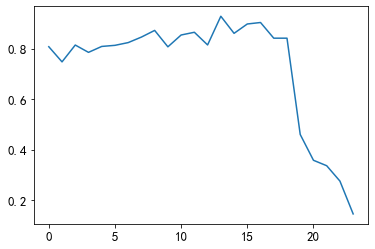

In [51]:
Cohort_Metric_2['Accuracy'].plot.line()

In [52]:
Cohort_Metric.sort_values('cohort',ascending = True)

,cohort,Users,Accuracy,Precision,Recall
0,200912.0,1030.0,0.808738,0.9420,0.5132
8,201001.0,382.0,0.748691,0.9358,0.5340
7,201002.0,363.0,0.815427,0.9453,0.6685
10,201003.0,426.0,0.786385,0.9222,0.6638
11,201004.0,284.0,0.809859,0.8976,0.7355
6,201005.0,253.0,0.814229,0.9113,0.7584
13,201006.0,263.0,0.825095,0.9308,0.7658
18,201007.0,183.0,0.846995,0.8936,0.8235
20,201008.0,158.0,0.873418,0.9067,0.8395
2,201009.0,240.0,0.808333,0.8594,0.7971
